In [52]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [53]:
dataset = 'data/signData.csv'
model_save_path = 'model/handSignClassifier.hdf5'

In [54]:
NUM_SIGNS = 6
X_data = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 43)))
y_data = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.75, random_state=RANDOM_SEED)

In [55]:
# Set up the layers of the deep network
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_SIGNS, activation='softmax')
])

In [56]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 42)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                860       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Set up the training parameters for the model
check_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [58]:
# Train the model for 1500 epochs
model.fit(
    X_train,
    y_train,
    epochs=1500,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[check_callback, stopping_callback]
)

Epoch 1/1500
45/79 [================>.............] - ETA: 0s - loss: 1.8090 - accuracy: 0.2003 
Epoch 1: saving model to model\handSignClassifier.hdf5
79/79 [==============================] - 1s 3ms/step - loss: 1.7599 - accuracy: 0.2222 - val_loss: 1.5707 - val_accuracy: 0.4463
Epoch 2/1500
42/79 [==============>...............] - ETA: 0s - loss: 1.6367 - accuracy: 0.3006
Epoch 2: saving model to model\handSignClassifier.hdf5
79/79 [==============================] - 0s 3ms/step - loss: 1.6096 - accuracy: 0.3235 - val_loss: 1.3858 - val_accuracy: 0.5953
Epoch 3/1500
41/79 [==============>...............] - ETA: 0s - loss: 1.5313 - accuracy: 0.3586
Epoch 3: saving model to model\handSignClassifier.hdf5
79/79 [==============================] - 

In [59]:
model_loss, model_accuracy = model.evaluate(X_test, y_test, batch_size=128)

14/14 [==============================] - 0s 1ms/step - loss: 0.2899 - accuracy: 0.9816


In [60]:
model = tf.keras.models.load_model(model_save_path)

In [61]:
# Print a sample prediction from the trained network
prediction = model.predict(np.array([X_test[1]]))
print(np.squeeze(prediction)) # The probability scores of each class
print(np.argmax(np.squeeze(prediction)))

[0.00089873 0.09623522 0.26352268 0.04345996 0.22968633 0.36619714]
5


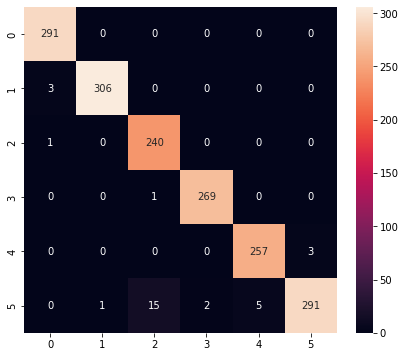

Model Performance Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       291
           1       1.00      0.99      0.99       309
           2       0.94      1.00      0.97       241
           3       0.99      1.00      0.99       270
           4       0.98      0.99      0.98       260
           5       0.99      0.93      0.96       314

    accuracy                           0.98      1685
   macro avg       0.98      0.98      0.98      1685
weighted avg       0.98      0.98      0.98      1685



In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def show_performance_report(true_vals, report=True):
    """
    Displays a confusion matrix and performance metrics of our model
    """
    labels = sorted(list(set(true_vals)))
    data = confusion_matrix(true_vals, y_pred, labels=labels)
    
    df = pd.DataFrame(data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(true_vals)), 0)
    plt.show()
    
    if report:
        print('Model Performance Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

show_performance_report(y_test)

In [63]:
# Save our model to the given path
model.save(model_save_path, include_optimizer=False)

In [64]:
# Save a TFlite model
tflite_save_path = 'model/handSignClassifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\dpate\AppData\Local\Temp\tmpfpcbmouz\assets


INFO:tensorflow:Assets written to: C:\Users\dpate\AppData\Local\Temp\tmpfpcbmouz\assets


6544